In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv(r'user_behavior_dataset.csv')
df.set_index('User ID', inplace=True)

In [3]:
#android vs iOS
#general comparison of market volumes
df['Operating System'].value_counts()

Operating System
Android    554
iOS        146
Name: count, dtype: int64

In [4]:
#means comparison - rejected because of big std values - new idea median zu nutzen
#df.describe()
means = df.groupby(['Operating System'])[['App Usage Time (min/day)','Screen On Time (hours/day)','Battery Drain (mAh/day)','Number of Apps Installed', 'Data Usage (MB/day)', 'Age']].mean()
gender_comp = df.groupby(['Operating System'])['Gender'].value_counts()
gender_comp

Operating System  Gender
Android           Male      292
                  Female    262
iOS               Female     74
                  Male       72
Name: count, dtype: int64

In [5]:
#comparing mean and median - unresolved, distribution didn't change
medians = df.groupby(['Operating System'])[['App Usage Time (min/day)','Screen On Time (hours/day)','Battery Drain (mAh/day)','Number of Apps Installed', 'Data Usage (MB/day)', 'Age']].median()
means

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age
Operating System,,,,,,
Android,268.258123,5.231047,1508.198556,50.142599,920.317690,38.357401
iOS,282.020548,5.430822,1589.513699,52.726027,965.506849,38.958904


In [6]:
medians

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age
Operating System,,,,,,
Android,225.0,4.80,1489.0,48.0,818.5,38.0
iOS,257.5,5.05,1538.5,52.0,907.0,39.0


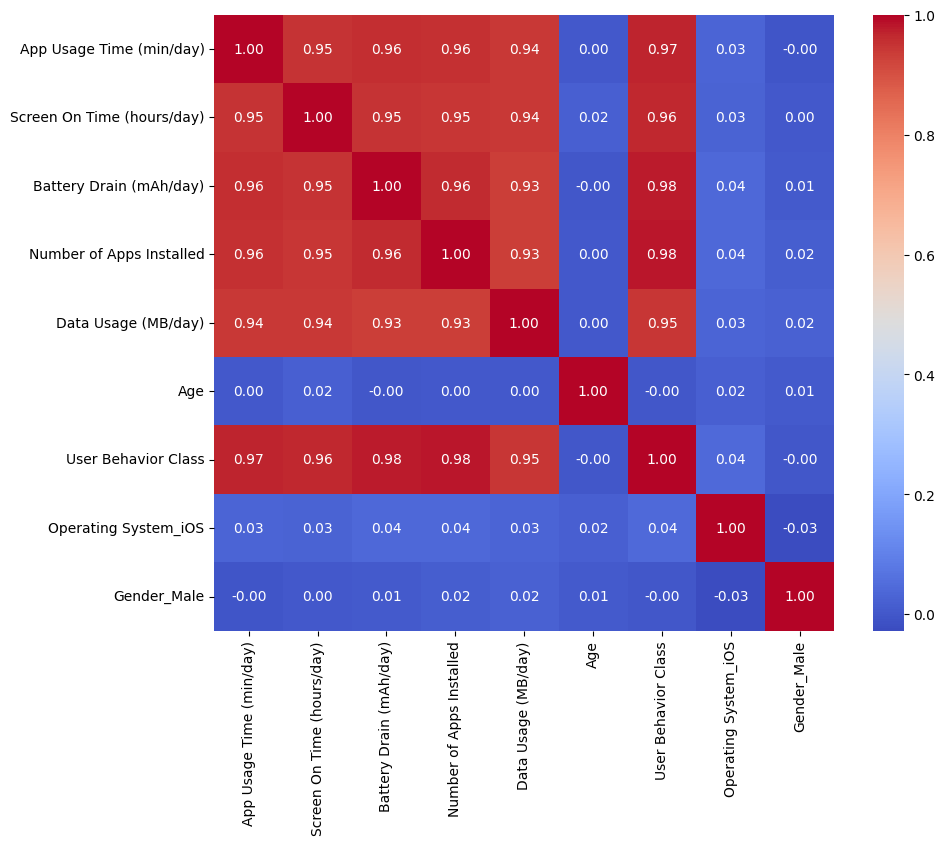

In [7]:
#1. building correlation matrix -- strong correlation between metrics and user behaviour class as well 2. multicollinearity problem
import matplotlib.pyplot as plt
import seaborn as sns
df_with_dummies = pd.get_dummies(df, columns=['Operating System', 'Gender'], drop_first=True)
df_with_dummies.drop(columns=['Device Model'], inplace=True)
correlation_matrix = df_with_dummies.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt = '.2f')
plt.show()

In [8]:
#logistic regression model
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
X = df_with_dummies[['App Usage Time (min/day)', 'Screen On Time (hours/day)', 
        'Battery Drain (mAh/day)', 'Number of Apps Installed', 'Data Usage (MB/day)']]
y = df['User Behavior Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LogisticRegression(max_iter=100000, penalty='l2')
model.fit(X_scaled,y)
print('Koeff: ', model.coef_)

Koeff:  [[-3.44057453 -3.85976532 -3.9494279  -4.3783584  -3.26480013]
 [-1.57420711 -1.1757579  -1.79050327 -1.36186111 -1.61941476]
 [-0.47826496  0.19384406  0.57417043  0.45516644  0.14883068]
 [ 2.08195905  1.28673465  2.0403483   2.05854532  1.29796423]
 [ 3.41108755  3.55494451  3.12541244  3.22650775  3.43741997]]


In [9]:
#according to VIF>10 for every variable we face a severe problems with multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_sc = pd.DataFrame(X_scaled, columns=['App Usage Time (min/day)', 'Screen On Time (hours/day)', 
                                           'Battery Drain (mAh/day)', 'Number of Apps Installed', 
                                           'Data Usage (MB/day)'])
vif = pd.DataFrame()
vif['Var'] = X_sc.columns
vif["VIF"] = [variance_inflation_factor(X_sc.values, i) for i in range(X_sc.shape[1])]
vif

,Var,VIF
0,App Usage Time (min/day),17.925828
1,Screen On Time (hours/day),15.113872
2,Battery Drain (mAh/day),18.478202
3,Number of Apps Installed,18.030193
4,Data Usage (MB/day),11.585403


<function matplotlib.pyplot.show(close=None, block=None)>

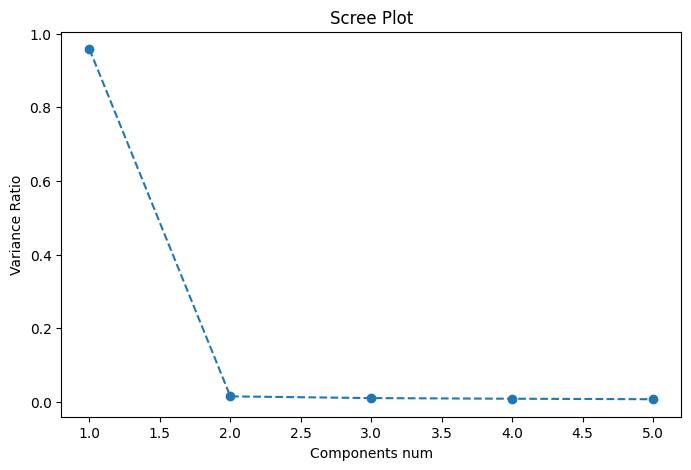

In [10]:
#1.resolving multicollinearity - PCA 2. searching for optimal ammount of principal components
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit(X_sc)
variance_exp = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.plot(range(1, len(variance_exp)+1), variance_exp, marker='o',linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Components num')
plt.ylabel('Variance Ratio')
plt.show

In [11]:
# according to Scree Plot the first component tends to describe about 90% of variance,
# but what the first component consists of?
pca_components = pca.components_
print('First component: ', pca_components[0])
print('Second component: ', pca_components[1])
# for 1 component: We see that the coefficients appear to be similar and have significant values,
# indicating that all coefficients are important.
# for 2 component: Data Usage (MB/day) is here the most important key 

First component:  [0.44872846 0.44715296 0.44828675 0.44822654 0.4436541 ]
Second component:  [-0.10043057  0.10424949 -0.42746183 -0.37666371  0.80897873]


In [12]:
# logistische regression
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
X = df_with_dummies[['App Usage Time (min/day)', 'Screen On Time (hours/day)', 
        'Battery Drain (mAh/day)', 'Number of Apps Installed', 'Data Usage (MB/day)']]
y = df['User Behavior Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)
print("explained variance with 2 components", pca.explained_variance_ratio_)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accur = accuracy_score(y_test, y_pred)
print("Accuracy is: ", accur)

explained variance with 2 components [0.95765518 0.01529263]
Accuracy is:  1.0


In [13]:
scores = cross_val_score(model, X_pca, y, cv=5)
print("Accuracy with cross validating:", scores.mean())

Accuracy with cross validating: 1.0


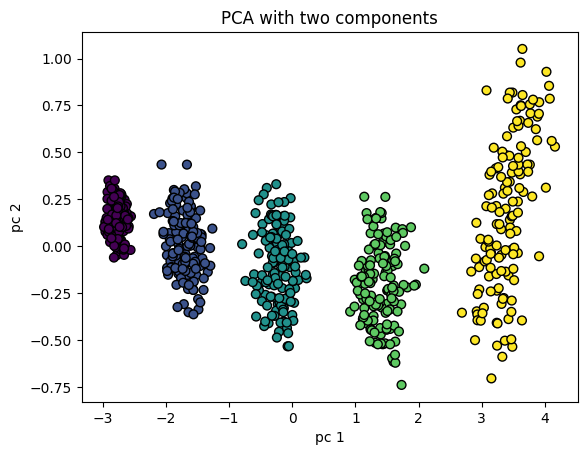

User Behavior Class
2    146
3    143
4    139
5    136
1    136
Name: count, dtype: int64

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.xlabel('pc 1')
plt.ylabel('pc 2')
plt.title('PCA with two components')
plt.show()
df['User Behavior Class'].value_counts()

In [15]:
# Means for all components => As we observe, the "Behavior Class" seems to represent the general time spent on the phone.
df['Klasse'] = y
klasse_means = df.groupby('Klasse').mean(numeric_only=True)
print("Durchschnittswerte aller Merkmale pro Klasse:")
print(klasse_means)

Durchschnittswerte aller Merkmale pro Klasse:
        App Usage Time (min/day)  Screen On Time (hours/day)  \
Klasse                                                         
1                      60.426471                    1.490441   
2                     131.972603                    3.037671   
3                     235.398601                    4.955944   
4                     395.748201                    6.909353   
5                     541.419118                   10.114706   

        Battery Drain (mAh/day)  Number of Apps Installed  \
Klasse                                                      
1                    454.977941                 14.558824   
2                    883.808219                 30.753425   
3                   1515.055944                 50.000000   
4                   2105.805755                 69.920863   
5                   2701.014706                 89.250000   

        Data Usage (MB/day)        Age  User Behavior Class  
Klasse         

In [23]:
#clustering - ?